In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
from IPython.display import clear_output
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import pickle
from matplotlib import cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

In [5]:
import NeuralODE as node

## Neural ODE implementation

In [ ]:
# ode_true = NeuralODE(SpiralFunctionExample())
# ode_trained = NeuralODE(RandomLinearODEF())

# conduct_experiment(ode_true, ode_trained, 500, "linear")

# func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]),
#                 Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
# ode_true = NeuralODE(func)

# func = NNODEF(2, 16, time_invariant=True)
# ode_trained = NeuralODE(func)

# conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)   

In [39]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 10

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

In [40]:
xs_list = []
for i in tqdm(range(num_spirals)):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = node.LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = node.NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

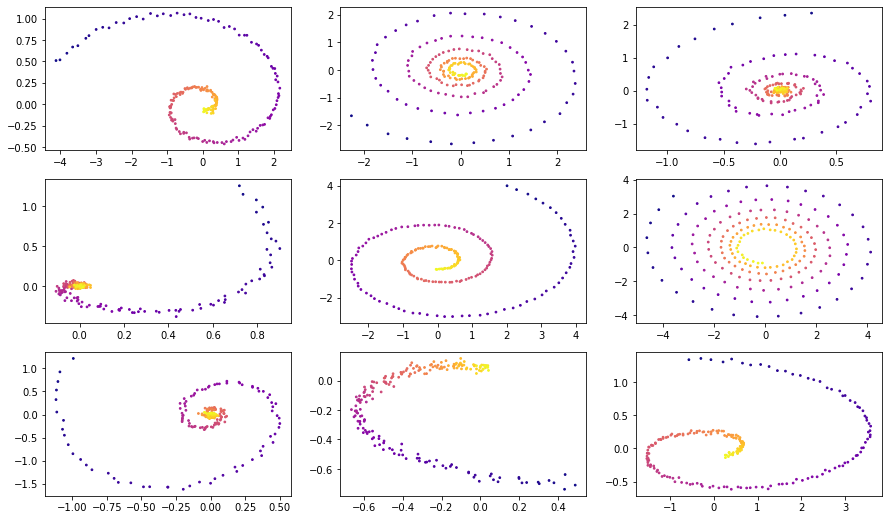

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0],
               cmap=cm.plasma, s=3)
plt.show()

In [36]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            probs = [1. / (time_len - n_sample)] * (time_len - n_sample)
            t0_idx = npr.multinomial(1, probs)
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

In [19]:
def to_np(x):
    return x.detach().cpu().numpy()

In [45]:
vae = node.ODEVAE(2, 128, 12)
vae = vae.cuda()
use_cuda = True
if use_cuda:
    vae = vae.cuda()

optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

preload = False
n_epochs = 20000
batch_size = num_spirals // 2

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

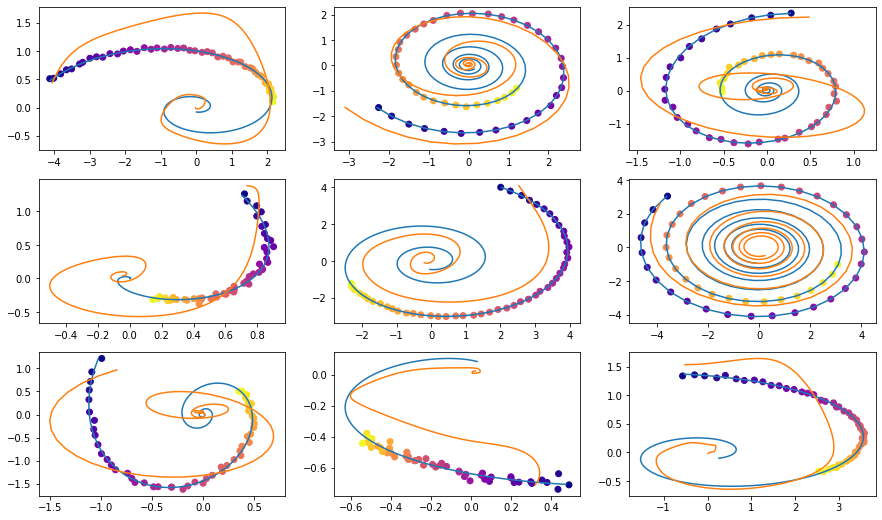

74.23543548583984 74.23543548583984
Epoch 2001
Epoch 2002
Epoch 2003
Epoch 2004
Epoch 2005


KeyboardInterrupt: ignored

In [48]:
for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size, 100)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice(np.linspace(50, n_points, 5, dtype=int))
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)

        z_var = torch.exp(z_log_var)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - z_var, -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, n_points, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    if epoch_idx % 10 == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
        axes = axes.flatten()
        for i, ax in enumerate(axes):
            ax.scatter(to_np(seed_trajs[:, i, 0]),
                      to_np(seed_trajs[:, i, 1]),
                      c=to_np(ts[frm:to_seed, i, 0]),
                      cmap=cm.plasma)
            ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
            ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
        plt.show()

        print(np.mean(losses), np.median(losses))

In [ ]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()

torch.save(vae.state_dict(), "models/vae_spirals.sd")